<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/baselines/FineTuning-v2_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Jul  4 16:12:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from copy import copy
from copy import deepcopy

#### Cloning the Git repository

In [3]:
!rm -rf ProjectMLDL
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

Cloning into 'ProjectMLDL'...
remote: Enumerating objects: 1914, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (326/326), done.
remote: Total 1914 (delta 271), reused 73 (delta 73), pack-reused 1514
Receiving objects: 100% (1914/1914), 77.65 MiB | 32.29 MiB/s, done.
Resolving deltas: 100% (1017/1017), done.
/content/ProjectMLDL


In [4]:
from data.cifar100 import CIFAR100
from model.resnet32 import resnet32
import data.utils
from model.trainer import Trainer

#### Downloading data from Cifar100

In [5]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

## Fine Tuning

### Defining hyperparameters according to iCarl paper

In [6]:
# Settings
DEVICE = 'cuda'
NUM_CLASSES = 100         # Total number of classes
VAL_SIZE = 0.2            # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 128          # Batch size
LR = 1 #2                    # Initial learning rate
                       
MOMENTUM = 0.9            # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5       # Weight decay from iCaRL

RANDOM_SEED = [24,66,32]  # Random seeds defining the runs of every method
                          # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70           # Total number of training epochs
MILESTONES = [27, 49, 63]#[49, 63]     # Step down policy from iCaRL (MultiStepLR)
                          # Decrease the learning rate by gamma at each milestone
GAMMA = 0.25               # Gamma factor from iCaRL (1/5)

### Going on with the model
This is the main FineTuning step.

This step is run 3 times with different `RANDOM_SEED`.
Here the model is instantiated, trained and tested.

Results and some statistics are then stored in the variable `logs`.

In [7]:
def do_group_classes(run):

  train_dataloader = [[] for i in range(10)]
  val_dataloader = [[] for i in range(10)]
  test_dataloader = [[] for i in range(10)]

  for i in range(10):
    train_data = CIFAR100("dataset", 
                          train=True, 
                          transform=train_transform, 
                          download=(run+i==0),
                          random_state=RANDOM_SEED[run])
    test_data = CIFAR100("dataset", 
                         train=False, 
                         transform=test_transform, 
                         download=False,
                         random_state=RANDOM_SEED[run])
    
    train_data.set_index_map(train_data.splits[i])
    test_data.set_index_map([test_data.splits[j] for j in range(0, i+1)])
    
    train_indices, val_indices = train_data.train_val_split(VAL_SIZE, RANDOM_SEED[run])
    
    train_subset = Subset(train_data, train_indices)
    val_subset = Subset(train_data, val_indices)

    tmp_dl = DataLoader(train_subset,
                       batch_size=BATCH_SIZE,
                       shuffle=True, 
                       num_workers=4,
                       drop_last=True)
    train_dataloader[i] = copy(tmp_dl)
    
    tmp_dl = DataLoader(val_subset,
                       batch_size=BATCH_SIZE,
                       shuffle=True, 
                       num_workers=4,
                       drop_last=True)
    val_dataloader[i] = copy(tmp_dl)

    tmp_dl = DataLoader(test_data,
                       batch_size=BATCH_SIZE,
                       shuffle=True, 
                       num_workers=4,
                       drop_last=True)
    test_dataloader[i] = copy(tmp_dl)

  return train_dataloader, val_dataloader, test_dataloader

In [8]:
logs = [[] for i in range(len(RANDOM_SEED))]
best_net_tot_classes = [None for i in range(len(RANDOM_SEED))]

for run in range(len(RANDOM_SEED)):
  random.seed(RANDOM_SEED[run])
  print("#################################")
  print(f"Radom seed: {RANDOM_SEED[run]}")
  print("")

  #get dataloader separated in incremental groups of 10 classes
  train_dl, val_dl, test_dl = do_group_classes(run)

  #create the resnet
  net = resnet32()
  
  trainer = Trainer(DEVICE,
                    net,
                    LR,
                    MOMENTUM,
                    WEIGHT_DECAY,
                    MILESTONES,
                    GAMMA,
                    train_dl,
                    val_dl,
                    test_dl)

  #train and evaluate the model
  logs[run] = trainer.train_model(NUM_EPOCHS)

  best_net_tot_classes[run] = deepcopy(trainer.best_net)

  print("#################################")
  print("")
  print("")

#################################
Radom seed: 24




Extracting dataset/cifar-100-python.tar.gz to dataset


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Output streaming troncato alle ultime 5000 righe.
Epoch 36/70 LR: [0.25]
Validation accuracy on group 9/10: 0.79

Epoch 37/70 LR: [0.25]
Validation accuracy on group 9/10: 0.79

Epoch 38/70 LR: [0.25]
Validation accuracy on group 9/10: 0.80

Epoch 39/70 LR: [0.25]
Validation accuracy on group 9/10: 0.78

Epoch 40/70 LR: [0.25]
Validation accuracy on group 9/10: 0.79

Epoch 41/70 LR: [0.25]
Validation accuracy on group 9/10: 0.80

Epoch 42/70 LR: [0.25]
Validation accuracy on group 9/10: 0.79

Epoch 43/70 LR: [0.25]
Validation accuracy on group 9/10: 0.80

Epoch 44/70 LR: [0.25]
Validation accuracy on group 9/10: 0.80

Epoch 45/70 LR: [0.25]
Validation accuracy on group 9/10: 0.80

Epoch 46/70 LR: [0.25]
Validation accuracy on group 9/10: 0.79

Epoch 47/70 LR: [0.25]
Validation accuracy on group 9/10: 0.80

Epoch 48/70 LR: [0.25]
Validation accuracy on group 9/10: 0.79

Epoch 49/70 LR: [0.25]
Validation accuracy on group 9/10: 0.79

Epoch 50/70 LR: [0.0625]
Validation accuracy on group 

### Store logs in more usable dtype

In [9]:
train_loss = [[logs[run_i]['group_train_loss'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
train_accuracy = [[logs[run_i]['group_train_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
val_loss = [[logs[run_i]['val_losses'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
val_accuracy = [[logs[run_i]['val_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
test_accuracy = [[logs[run_i]['test_accuracies'][i] for i in range(10)] for run_i in range(len(RANDOM_SEED))]
predictions = [logs[run_i]['predictions'].cpu().data.numpy().tolist() for run_i in range(len(RANDOM_SEED))]
true_labels = [logs[run_i]['true_labels'].cpu().data.numpy().tolist() for run_i in range(len(RANDOM_SEED))]

### Save the model

#### Saving logs in JSON files

In [10]:
import json

with open('states/FineTuning_train_loss.json', 'w') as f:
  json.dump(train_loss, f)
f.close
with open('states/FineTuning_train_accuracy.json', 'w') as f:
  json.dump(train_accuracy, f)
f.close
with open('states/FineTuning_val_loss.json', 'w') as f:
  json.dump(val_loss, f)
f.close  
with open('states/FineTuning_val_accuracy.json', 'w') as f:
  json.dump(val_accuracy, f)
f.close
with open('states/FineTuning_test_accuracy.json', 'w') as f:
  json.dump(test_accuracy, f)
f.close
with open('states/FineTuning_predictions.json', 'w') as f:
  json.dump(predictions, f)
f.close
with open('states/FineTuning_true_labels.json', 'w') as f:
  json.dump(true_labels, f)
f.close

<function TextIOWrapper.close>

#### Saving best resnet on 100 classes for each seed

In [11]:
for i in range(len(RANDOM_SEED)):
  torch.save(best_net_tot_classes[i].state_dict(), "states/FineTuning_bestnet_seed[{}]".format(RANDOM_SEED[i]))

In [ ]:
from google.colab import files
files.download('states/FineTuning_train_loss.json')
files.download('states/FineTuning_train_accuracy.json')
files.download('states/FineTuning_val_loss.json')
files.download('states/FineTuning_val_accuracy.json')
files.download('states/FineTuning_test_accuracy.json')
files.download('states/FineTuning_predictions.json')
files.download('states/FineTuning_true_labels.json')
files.download('states/FineTuning_bestnet_seed[24]')
files.download('states/FineTuning_bestnet_seed[66]')
files.download('states/FineTuning_bestnet_seed[32]')

### Print some graphs

In [14]:
from data.utils_plot import plot_train_val, plot_test_accuracies, plot_confusion_matrix

In [15]:
train_loss = np.array(train_loss)
train_accuracy = np.array(train_accuracy)
val_loss = np.array(val_loss)
val_accuracy = np.array(val_accuracy)
test_accuracy = np.array(test_accuracy)

train_loss_stats = np.array([train_loss.mean(0), train_loss.std(0)]).transpose()
train_accuracy_stats = np.array([train_accuracy.mean(0), train_accuracy.std(0)]).transpose()
val_loss_stats = np.array([val_loss.mean(0), val_loss.std(0)]).transpose()
val_accuracy_stats = np.array([val_accuracy.mean(0), val_accuracy.std(0)]).transpose()
test_accuracy_stats = np.array([test_accuracy.mean(0), test_accuracy.std(0)]).transpose()

#### Train validation loss

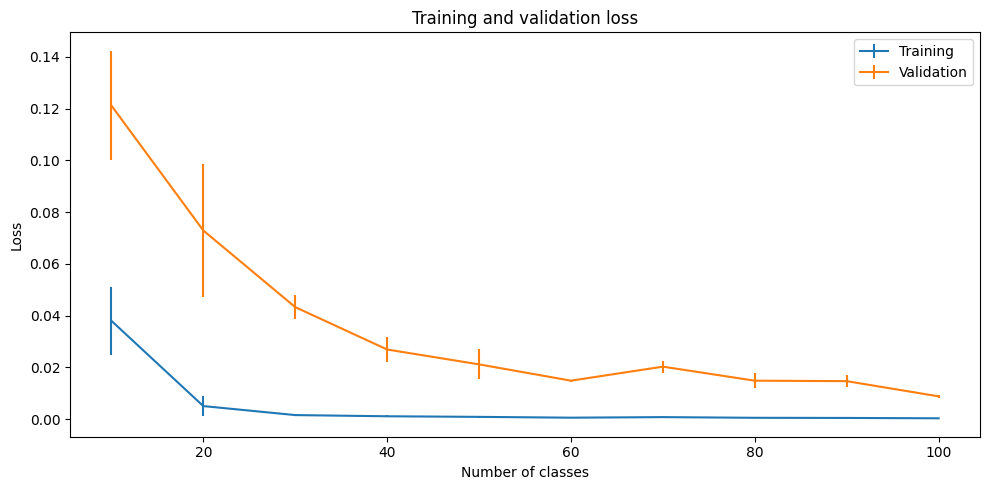

In [16]:
plot_train_val(train_loss_stats, val_loss_stats, loss = True)

#### Train validation accuracy

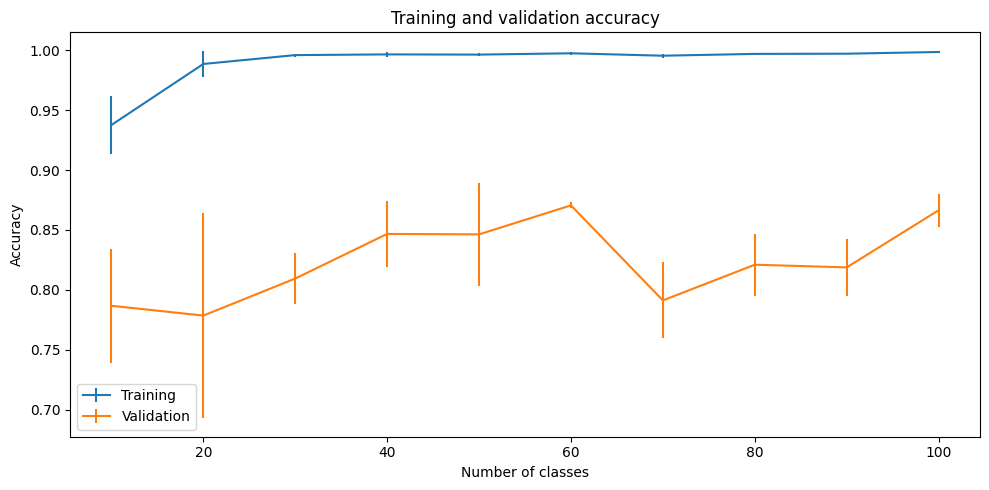

In [17]:
plot_train_val(train_accuracy_stats, val_accuracy_stats, loss = False)

#### Test accuracy

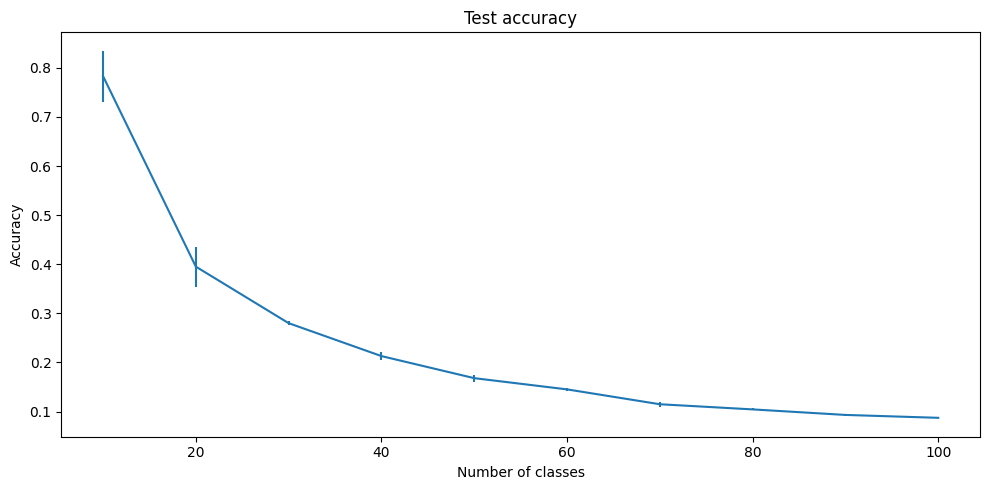

In [18]:
plot_test_accuracies(test_accuracy_stats)

#### Confusion Matrix

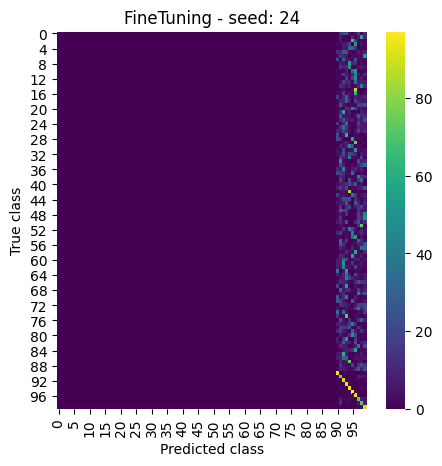

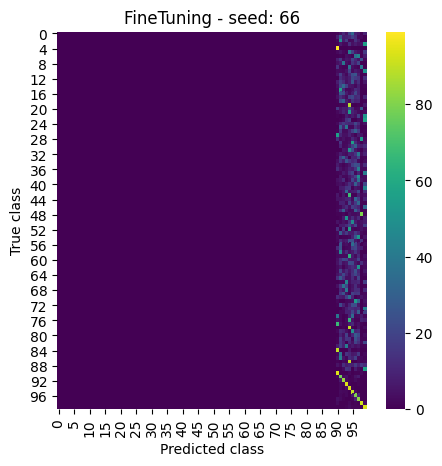

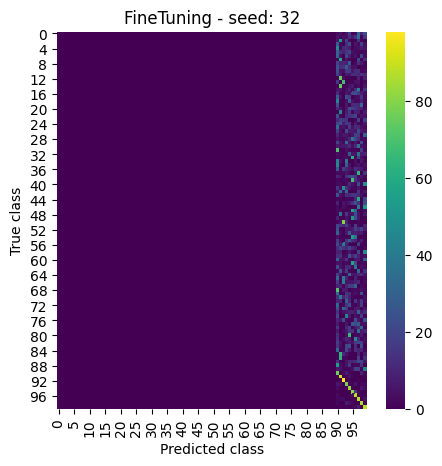

In [19]:
for run in range(len(RANDOM_SEED)):
  targets = logs[run]['true_labels'].cpu().data.numpy()
  preds = logs[run]['predictions'].cpu().data.numpy()

  plot_confusion_matrix(targets, preds, RANDOM_SEED[run], 'FineTuning')